# Genetic TSP
Introduction: 
travelling salesman is a NP-hard problem, which means it is impossible to solve it in polynomial time. However, we can use genetic algorithm to find a good solution in a reasonable time. 

Genetic algorithm is a heuristic search algorithm inspired by the process of natural selection. It is based on the idea of evolution, where the fittest individuals are selected for reproduction in order to produce offspring of the next generation.


## 1. Setup

We first need to setup our environment. If you are new to Python or Jupyter Notebooks, it is recommended to use cloud services like Google Colab, as it provides an already setup environment for you to work with. Otherwise, you need to install the following libraries on your local machine: 

In [209]:
%pip install numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [210]:
# make sure to import the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Matrix initialization, and solution representation
We need to represent the problem in a way that the algorithm can understand. We will use a matrix to represent the distances between cities. We will also represent the solution as a list of cities.
$$
n \equiv \text{number of cities} \quad n\in\mathbb{N}\\
C_{i} \equiv  i^{th} \text { City} \quad i\in[0,n-1]\\
$$

The distance matrix $D$ can be defined as follows:
$$
D \in \mathbb{R}^{n\times n} \quad \\
D_{ij} \equiv \text{Distance between city } C_{i} \text{ and city } C_{j} \quad i,j\in[0,n-1]\\
$$


In [211]:
# load distance matrix from a file
def load_distance_matrix(filename):
    with open(filename) as f:
        lines = f.readlines()
    n = len(lines)
    d_matrix = np.zeros((n, n))
    for i, line in enumerate(lines):
        d_matrix[i] = list(map(float, line.split()))
    return d_matrix

# plot cost matrix as a heatmap
def plot_distance_matrix(d_matrix):
    sns.heatmap(d_matrix, cmap='viridis')
    plt.show()


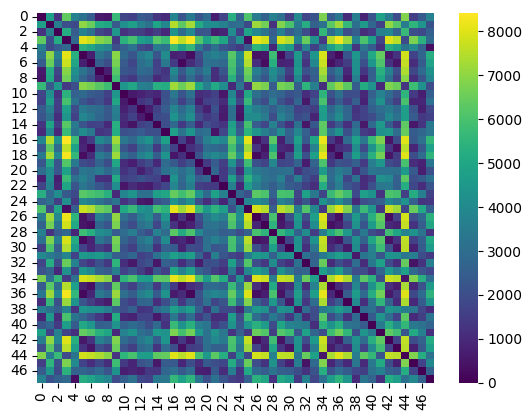

In [212]:
# Datasets were obtained from https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html
# feel free to test out the code with other datasets as long as they are in the same format (take a look into dataset/att48_d.txt for an example)
file = "dataset/att48_d.txt" # change this to the path of the file you want to plot

distance_matrix = load_distance_matrix(file)
plot_matrix(distance_matrix)

A solution $S$ may be represented as a permutation of cities, the first city being the starting city:
$$
S = \set{C_{0},C_{1},C_{2},\ldots,C_{n-1}}!
$$

In [213]:
NUMBER_OF_CITIES = distance_matrix[0].size

def random_solution(num_cities: int):
    return np.random.permutation(num_cities)

solution = random_solution(NUMBER_OF_CITIES)

Finally we need to define an evaluator to calculate the objective function $z$. In this case, the objective function is the total distance of the path:
$$
\min{z} = \sum_{i=0}^{n-2} D_{S_{i}S_{i+1}} + D_{S_{n-1}S_{0}}
$$

In [214]:
def evaluate(solution, d_matrix):
    total_distance = 0
    for i in range(len(solution)):
        total_distance += d_matrix[solution[i]][solution[(i+1)%len(solution)]]
    total_distance += d_matrix[solution[-1]][solution[0]]
    return total_distance


In [215]:
# We may test out the evaluator with the random solution.
z_random = evaluate(solution, distance_matrix)
print("Random solution distance: ", z_random)

Random solution distance:  154985.0


## 2. Greedy Algorithm (Nearest Neighbour)
Before delving into genetic algorithms, let's first implement a simple greedy algorithm to solve the TSP. The nearest neighbour algorithm is a simple and effective heuristic algorithm that starts from a random city and then selects the nearest unvisited city as the next city to visit. This process is repeated until all cities are visited. The algorithm is as follows:

1. Start from a random city $C_{0}$.
2. While there are unvisited cities:
    1. Select the nearest unvisited city $C_{i}$ to the current city $C_{j}$.
    2. Mark $C_{i}$ as visited.
    3. Set $C_{j} = C_{i}$.
3. Return to the starting city $C_{0}$.


In [216]:
def greedy_approach(d_matrix):
    solution = [0]
    visited = [False] * NUMBER_OF_CITIES
    visited[0] = True
    for _ in range(NUMBER_OF_CITIES - 1):
        last_city = solution[-1]
        best_neighbour = None
        best_distance = float('inf')
        for i in range(NUMBER_OF_CITIES):
            if not visited[i] and d_matrix[last_city][i] < best_distance:
                best_neighbour = i
                best_distance = d_matrix[last_city][i]
        solution.append(best_neighbour)
        visited[best_neighbour] = True
    return solution


In [217]:
# We may test out the evaluator with the greedy solution.
greedy_solution = greedy_approach(distance_matrix)
z_greedy = evaluate(greedy_solution, distance_matrix)
print("Random solution distance: ", z_random)
print("Greedy solution distance: ", z_greedy)


Random solution distance:  154985.0
Greedy solution distance:  41114.0


## 3. Genetic Algorithm
Genetic algorithms are inspired by the process of natural selection. They are based on the idea of evolution, where the fittest individuals are selected for reproduction in order to produce offspring of the next generation. The algorithm follows these steps:

1. **Initialization**: Create an initial population of individuals.
2. **Evaluation**: Evaluate the fitness of each individual in the population.
3. **Selection**: Select the fittest individuals to reproduce.
4. **Crossover**: Create offspring by combining the genetic material of the selected individuals.
5. **Mutation**: Introduce random changes in the offspring.
6. **Replacement**: Replace the least fit individuals in the population with the offspring.
7. **Termination**: Repeat steps 2-6 until a termination condition is met. (*)

(*) Should there be no termination condition, the algorithm will run indefinitely. The termination condition can be a fixed number of generations, a fixed amount of time, or a convergence criterion. 


### 3.1 Initialization
The first step in the genetic algorithm is to create an initial population of individuals. Each individual represents a possible solution to the problem. In the case of the TSP, an individual is a permutation of the cities. The population size is a parameter that can be adjusted to balance the exploration-exploitation trade-off. A larger population size increases the diversity of the population but also increases the computational cost.

In this implementation, we will generate a random population of individuals. Each individual is a permutation of the cities, starting from a random city. The population size is a parameter that can be adjusted.

In [218]:
def generate_population(population_size, num_cities):
    return np.array([random_solution(num_cities) for _ in range(population_size)])
    

In [219]:
# We need to generate a population of random solutions.
population = generate_population(population_size, NUMBER_OF_CITIES)
print("Random population: \n", population)

Random population: 
 [[37 38  9 ... 40 17 25]
 [42  5 30 ... 45 33 16]
 [ 1 20 33 ... 19 34 23]
 ...
 [ 3 24 43 ... 20  4  8]
 [36 40 12 ... 37  9 45]
 [ 5 20 18 ... 29 30 44]]


### 3.2 Evaluation
The next step is to evaluate the fitness of each individual in the population. The fitness of an individual is determined by the objective function, which in this case is the total distance of the path. The lower the total distance, the higher the fitness of the individual.


In [220]:
def evaluate_population(population, d_matrix):
    return np.array([evaluate(solution, d_matrix) for solution in population])
    

### 3.3 Selection
The selection step is where the fittest individuals are chosen to reproduce. There are several selection methods, such as roulette wheel selection, tournament selection, and rank-based selection. In this implementation, we will use roulette wheel selection, which selects individuals with a probability proportional to their fitness. This means that fitter individuals are more likely to be selected for reproduction.


In [221]:
def roulette_selection(population, fitness):
    probabilities = fitness / fitness.sum()
    return population[np.random.choice(np.arange(len(population)), p=probabilities)]
    

### 3.4 Crossover
The crossover step is where offspring are created by combining the genetic material of the selected individuals. There are several crossover methods, such as one-point crossover, two-point crossover, and uniform crossover. In this implementation, we will use ordered crossover, which preserves the order of the cities in the parents.


In [222]:
def ordered_crossover(parent1, parent2):
    n = len(parent1)
    i, j = np.random.choice(n, 2, replace=False)
    i, j = min(i, j), max(i, j)
    
    child = -1 * np.ones(n)
    child[i:j] = parent1[i:j]
    
    k = 0
    for l in range(n):
        if k == i:  # Skip the filled segment
            k = j
        if parent2[l] not in child:
            child[k] = parent2[l]
            k += 1
            
    return child


### 3.5 Mutation
The mutation step introduces random changes in the offspring to maintain genetic diversity in the population. There are several mutation methods, such as swap mutation, inversion mutation, and scramble mutation. In this implementation, we will use swap mutation, which swaps two cities in the offspring.

In [223]:
def swap_mutation(solution):
    i, j = np.random.choice(len(solution), 2, replace=False)
    solution[i], solution[j] = solution[j], solution[i]
    return solution

### 3.6 Replacement
The replacement step is where the least fit individuals in the population are replaced by the offspring. There are several replacement methods, such as generational replacement, elitist replacement, and steady-state replacement. In this implementation, we will use generational replacement, where the entire population is replaced by the offspring.

In [224]:
def replace_worst(population, fitness, new_solution):
    worst_idx = np.argmax(fitness)
    population[worst_idx] = new_solution
    return population

### 3.7 Termination
The termination step is where the algorithm stops when a termination condition is met. The termination condition can be a fixed number of generations, a fixed amount of time, or a convergence criterion. In this implementation, we will use a fixed number of generations as the termination condition.

In [225]:
def genetic_algorithm(matrix, population_size, generations):
    population = generate_population(population_size, NUMBER_OF_CITIES)
    fitness = evaluate_population(population, matrix)
    convergence = np.zeros(generations)
    for i in range(generations):
        parent1 = roulette_selection(population, fitness)
        parent2 = roulette_selection(population, fitness)
        child = ordered_crossover(parent1, parent2)
        child = swap_mutation(child)

        population = replace_worst(population, fitness, child)
        fitness = evaluate_population(population, matrix)
        
        best_population_z = fitness.min()
        convergence[i] = best_population_z
        population_mean_z = fitness.mean()

        print(f"Generation: {i}, Best solution: {best_population_z}, Mean solution: {population_mean_z}")
    return population, fitness, convergence


In [226]:
population_size = 100 # change this to the desired population size
n_of_generations = 10000 # change this to the desired number of generations

population, fitness, convergence = genetic_algorithm(distance_matrix, population_size, n_of_generations)
print("Final population: \n", population)
print("Final fitness: \n", fitness)

best_solution = population[np.argmin(fitness)]
z_best = evaluate(best_solution, distance_matrix)
print("Best solution: \n", best_solution)
print("Best solution distance: ", z_best)

Generation: 0, Best solution: 131881.0, Mean solution: 160230.7
Generation: 1, Best solution: 131881.0, Mean solution: 159786.3
Generation: 2, Best solution: 131881.0, Mean solution: 159462.35
Generation: 3, Best solution: 131881.0, Mean solution: 159232.22
Generation: 4, Best solution: 131881.0, Mean solution: 159163.76
Generation: 5, Best solution: 131881.0, Mean solution: 159167.41
Generation: 6, Best solution: 131881.0, Mean solution: 159017.01
Generation: 7, Best solution: 131881.0, Mean solution: 158873.4
Generation: 8, Best solution: 131881.0, Mean solution: 158652.27
Generation: 9, Best solution: 131881.0, Mean solution: 158626.97
Generation: 10, Best solution: 131881.0, Mean solution: 158372.53
Generation: 11, Best solution: 131881.0, Mean solution: 158021.52
Generation: 12, Best solution: 131881.0, Mean solution: 157937.39
Generation: 13, Best solution: 131881.0, Mean solution: 157701.7
Generation: 14, Best solution: 131881.0, Mean solution: 157578.36
Generation: 15, Best sol

## 4. Visualization
We have seen too much theory, let's visualize the algorithm in action. We have already visualized a matrix heatmap, now we will visualize more details about the problem, that will give us a retrospective of the algorithm.
1. **Path Visualization**: We will visualize the path of the salesman on the map.
2. **Convergence Visualization**: We will visualize the convergence of the algorithm over generations.

### 4.1 Path Visualization
We will visualize the path of the salesman on the map. For this we will use XY coordinates of the cities. We will plot the cities and the path connecting them.

In [227]:
# get the XY coordinates of the cities
def load_coordinates(filename):
    with open(filename) as f:
        lines = f.readlines()
    n = len(lines)
    coordinates = np.zeros((n, 2))
    for i, line in enumerate(lines):
        coordinates[i] = list(map(float, line.split()))
    return coordinates


In [228]:
# Feel free to test out the code with other datasets as long as they are in the same format (take a look into dataset/att48_xy.txt for an example)
file = "dataset/att48_xy.txt" # change this to the path of the file you want to plot
coordinates = load_coordinates(file)

In [229]:
## plot solutions with a tag of the city number
def plot_solution(coordinates, solution):
    plt.figure(figsize=(10, 10))
    plt.title("TSP Genetic Alg. solution")
    plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red')
    for i in range(len(solution)):
        city1 = solution[i]
        city2 = solution[(i+1)%len(solution)]
        plt.plot([coordinates[city1][0], coordinates[city2][0]], [coordinates[city1][1], coordinates[city2][1]], color='blue')
        plt.text(coordinates[city1][0], coordinates[city1][1], str(i))
    plt.show()

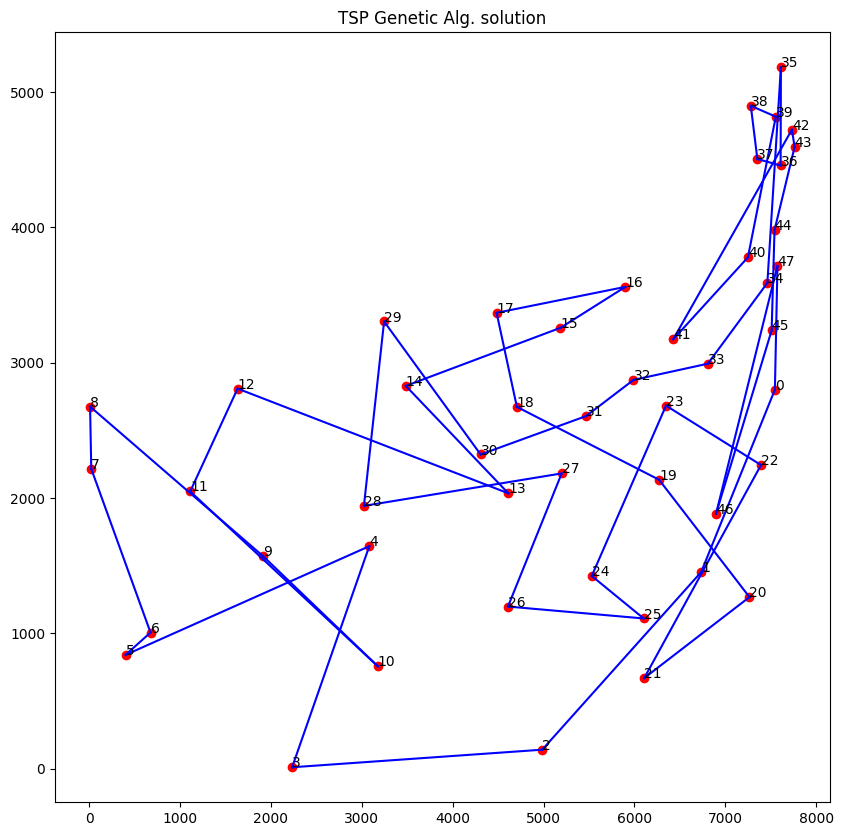

In [230]:
plot_solution(coordinates, best_solution)

### 4.2 Convergence Visualization
We will visualize the convergence of the algorithm over generations. The convergence plot shows the best fitness value found so far in each generation. The goal is to see how the fitness value improves over time and whether the algorithm is converging to a good solution.

In [231]:
def plot_convergence(convergence):
    plt.figure(figsize=(10, 5))
    plt.plot(convergence)
    plt.title("Population Best Solution Convergence")
    plt.xlabel("Generation")
    plt.ylabel("Distance")
    plt.show()

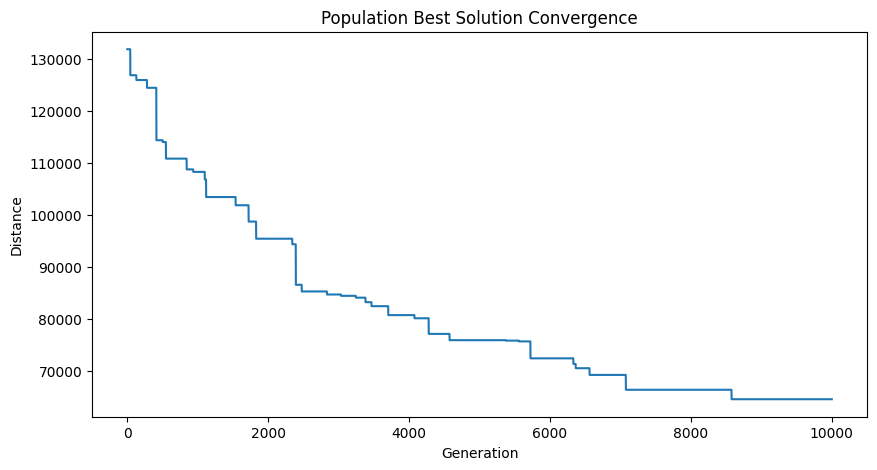

In [232]:
plot_convergence(convergence)

## 5. Conclusion
In this notebook, we have implemented a genetic algorithm to solve the travelling salesman problem. We have seen how the algorithm works and how it can be applied to solve combinatorial optimization problems. We have also visualized the algorithm in action to gain a better understanding of how it works. 

This project was inspired by Operations Research course at my university. I hope you have enjoyed it and learned something new. If you have any questions or feedback, feel free to reach out to me. Thank you for reading!

## 6. FAQ
Why is the greedy algorithm faster than the genetic algorithm? 
The greedy algorithm is faster than the genetic algorithm because it is a simple heuristic algorithm that does not require the computational overhead of genetic algorithms. The greedy algorithm is also more efficient in terms of memory usage, as it does not require the storage of a population of individuals. However, the greedy algorithm may not always find the optimal solution, as it makes locally optimal choices that may not lead to a globally optimal solution. In contrast, the genetic algorithm is a more robust optimization technique that can find good solutions to complex problems, but it requires more computational resources and time to converge to a solution.

Why is the solution of the greedy algorithm better than the genetic algorithm?
The solution of the greedy algorithm may be better than the genetic algorithm in some cases because the greedy algorithm makes locally optimal choices that may lead to a better solution in the short term. However, the greedy algorithm may get stuck in a local minimum and fail to find the globally optimal solution. In contrast, the genetic algorithm explores a larger search space and can find better solutions in the long term by combining genetic material from different individuals. Therefore we may need to run the genetic algorithm for more generations to find a better solution.

Why is TSP important?
The travelling salesman problem (TSP) is an important problem in combinatorial optimization and operations research. It has applications in logistics, transportation, and supply chain management, where it is used to optimize the routing of vehicles and delivery schedules. The TSP is also a classic problem in computer science and mathematics, and it has been studied extensively in the fields of optimization and algorithms. The TSP is a challenging problem because it is NP-hard, which means that it is difficult to solve in polynomial time. But as we have seen in this notebook, heuristic algorithms like the genetic algorithm can be used to find good solutions to the TSP in a reasonable time.

## 7. References
1. [Wikipedia - Travelling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)
2. [Wikipedia - Genetic Algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm)
3. [Genetic Algorithm for the Travelling Salesman Problem](https://towardsdatascience.com/genetic-algorithm-for-the-travelling-salesman-problem-69a052d8b15e)
4. Dataset: [TSP dataset](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html)